# Mitchell Pudil
## Econ 213R: Applied Machine Learning
## Homework 2: Kaggle House Prices

In [1]:
from IPython.display import HTML
HTML('<img src="http://www.clevver.com/wp-content/uploads/2014/04/office-michael-scott-declare-bankruptcy.gif">')


## We will begin by importing the appropriate packages that will be used later to analyze data

In [2]:
import pandas as pd # Allows to type pd to represent pandas 
import numpy as np # Allows for scientific computing
import matplotlib.pyplot as plt  # visualization
import seaborn as sns  # Allows for cleaner graphing capabilities

# Machine learning packages

from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer
from scipy import stats
from scipy.stats import norm, skew
from sklearn.preprocessing import LabelEncoder

# Don't show warnings (for presentation purposes)
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


## Importing training and test dataset

###  ID really isn't important to keep track of, so we will drop it from our training dataset.

In [3]:
train = pd.read_csv("/Users/mitchellpudil/Desktop/all/train.csv")  # Import dataset from csv
test = pd.read_csv("/Users/mitchellpudil/Desktop/all/test.csv")  # Import dataset from csv

train_id = train['Id']
train = train.drop(['Id'], axis=1)

test_Id = test['Id']
test.drop("Id", axis = 1, inplace = True)


train.columns   # Look at columns to make sure it read in and get a glimpse at what the columns are

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

## Let's take a look at missing data to clean up the dataset. We will do this in order to determine what variables need to be cleaned, and if so, think of ways to fix the problem

Text(0.5,1,'Percent missing data by feature')

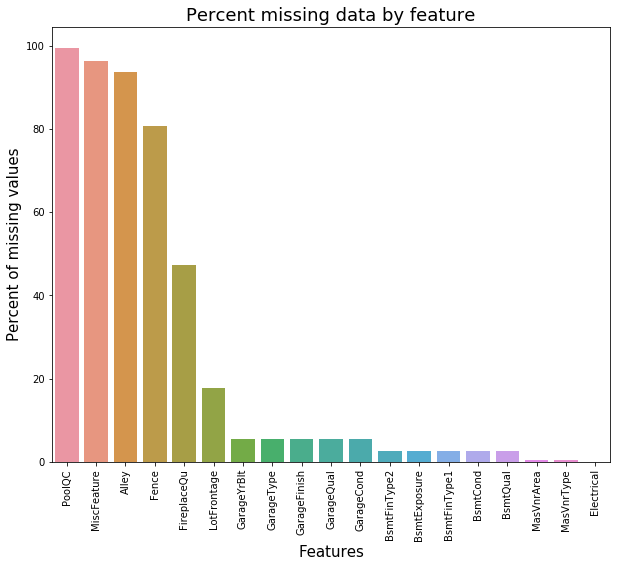

In [4]:
#Calculate missing data
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(30)

#Graph missing data as histogram
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=train_na.index, y=train_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=18)

# Code for missing data graph by githum member KartikeDutta


### Sice hardly anyone has a pool, pool quality is missing. Note also that Misc Feature refers to things like an elevator, 2nd garage, shed, tennis court, etc. An Na for an alley just means that there was no alley, so we'll fix that too. Same thing for fence, fireplace, garage type/finish/quality, basement quality. However, for lot frontage, we will need to replace some missing variables. This takes care of most of the problems related to missing values.



In [5]:
train_na.head(20)

PoolQC         99.521
MiscFeature    96.301
Alley          93.767
Fence          80.753
FireplaceQu    47.260
LotFrontage    17.740
GarageYrBlt     5.548
GarageType      5.548
GarageFinish    5.548
GarageQual      5.548
GarageCond      5.548
BsmtFinType2    2.603
BsmtExposure    2.603
BsmtFinType1    2.534
BsmtCond        2.534
BsmtQual        2.534
MasVnrArea      0.548
MasVnrType      0.548
Electrical      0.068
dtype: float64

In [6]:
train = train.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1)  # Drop features that have a lot (~50%)
# or more rows missing

### Since lot frontage is highly correlated with the type of neighborhood it is in, we will replace it by the median in the neighborhood category. Briefly, the variables I chose to fill in as 'None' are that because they were marked, but there was no corresponding appliance or feature of that house (garage, fireplace, etc.). The features I chose to fill in as a 0 I did because they were numericals that were missing. Those that I filled in as 'mode' were missing categoricals.

In [7]:
train["LotFrontage"] = train.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#Replace necessary missing data with "None"
for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'MasVnrArea'):
    train[col] = train[col].fillna('None')
    
for col in ('GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'MasVnrArea'):
    train[col] = train[col].fillna(0)
    
for col in ('Electrical', 'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'MasVnrType', 'MasVnrArea', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'): 
    train[col] = train[col].fillna(train[col].mode()[0]) 
    
train['TotalSqFt'] = train['LotArea'] + train['GrLivArea'] + train['GarageArea']+ train['1stFlrSF'] + train['TotalBsmtSF'] + train['BsmtUnfSF'] + train['LotFrontage'] + train['OpenPorchSF'] + train['OpenPorchSF'] + train['2ndFlrSF'] + train['WoodDeckSF']
train['Qual_Sq'] = np.square(train['OverallQual'])
train['Sq_Ft_Sq'] = np.square(train['TotalSqFt'])
   

In [8]:
# Recalculate missing data to make sure no variables were left out
train_na = (train.isnull().sum() / len(train)) * 100
train_na = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :train_na})
missing_data.head(30)

,Missing Ratio


### There are now no missing data, so we can move on to looking at correlations

# Correlations

### Now that we have filled in the missing data, let's take a look at correlations of the variables. This will help us figure out what features are correlated with sales price, which is important because we want to know where to look for outliers.


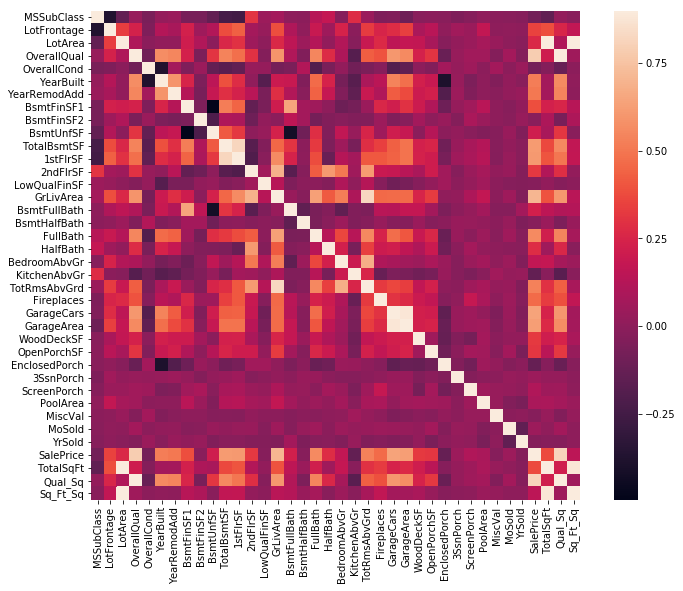

In [9]:
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

### Looking at the very bottom row, we know that lot area, garage living area, overall quality, garage cars, are positively correlated with sale price. 

### Other variables that weren't highly correlated with naturally be dropped when we reduce the number of features using Gradient Boosting.

### Note that cells that are a really dark purple are negatively correlated, while cells that are lighter, like orange or peach are highly correlated. 

# Feature Engineering

### Intuition tells us that the total square footage of the variables is necessary to include to estimate the price of the house, so we will include this variable before looking at the correlation

In [10]:
train['TotalSqFt'] = train['LotArea'] + train['GrLivArea'] + train['GarageArea']+ train['1stFlrSF'] + train['TotalBsmtSF'] + train['BsmtUnfSF'] + train['LotFrontage'] + train['OpenPorchSF'] + train['2ndFlrSF'] + train['WoodDeckSF']

### If we add a variable for quality squared, it separates even more bad houses from good houses

In [11]:
train['Qual_Sq'] = np.square(train['OverallQual'])

# Outliers
### In the following section, we will be focused on removing outliers, paying close attention to the variables that are highly correlated with sale price. We will start with total square footage, and then remove outliers for other features. We will begin by creating a function for this plot since we will be using it again after we get rid of the outliers.

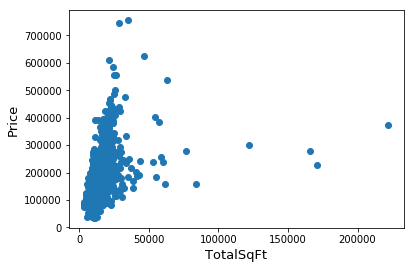

In [12]:
def plot_outlier(feature):
    fig, ax = plt.subplots() 
    ax.scatter(x = train[feature], y = train['SalePrice'])   # This takes the feature and plot it against sales price
    plt.ylabel('Price', fontsize=13)
    plt.xlabel(feature, fontsize=13)
    plt.show() 


plot_outlier('TotalSqFt')

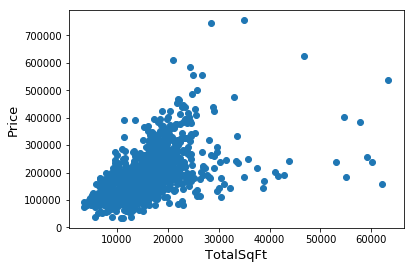

In [13]:
train = train.drop(train[(train['TotalSqFt']>75000) & (train['SalePrice']<450000)].index) # Dropping outliers, where
# square footage is greater than 4000 and sale price is less than 300,000

plot_outlier('TotalSqFt')  # Plot again to make sure we did get rid of outliers

### We see that there are a few outliers, especially with observations that were above 100,000 sq ft, so we will drop these.

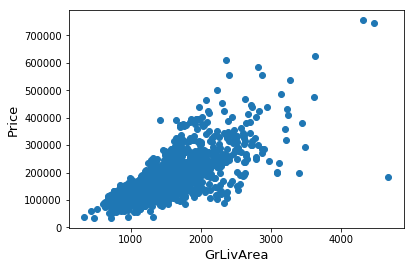

In [14]:
plot_outlier('GrLivArea')

### There are two observations around ( 5000, 200000 ), that are outliers. They had a large garage living area but sold for a low price 

In [15]:
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index) # Dropping outliers, where
# square footage is greater than 4000 and sale price is less than 300,000

### Plot again to make sure it got rid of the outlier

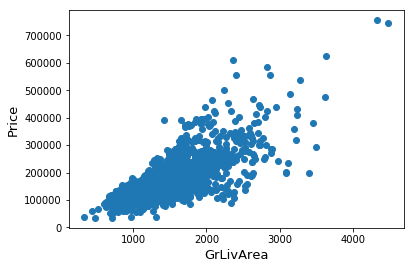

In [16]:
plot_outlier('GrLivArea')

### Before, we looked at outliers with just one of the square footage measurements. Let's do this same thing but with total square footage.

### Just to cover all our bases with these types of outliers, let's look at the other types of square footage against Price (or at least the ones that showed up in the most important variables list that will be shown later on).

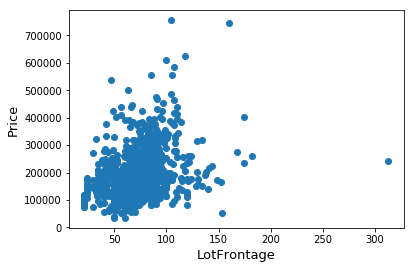

In [17]:
plot_outlier('LotFrontage')

In [18]:
train = train.drop(train[(train['LotFrontage']>250) & (train['SalePrice']<300000)].index) # Dropping outliers 
train = train.drop(train[(train['LotFrontage']>140) & (train['SalePrice']<100000)].index) # Dropping outliers 

### Just to save on space, I'm not going to show the plots of the features footage vs price, but I have looked through the rest and the code will get rid of the rest of the other outliers :) 

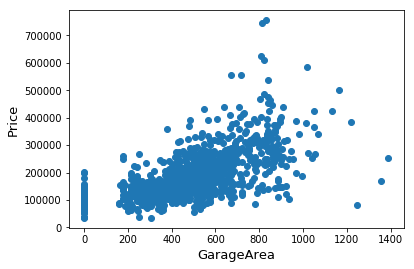

In [19]:
plot_outlier('GarageArea')

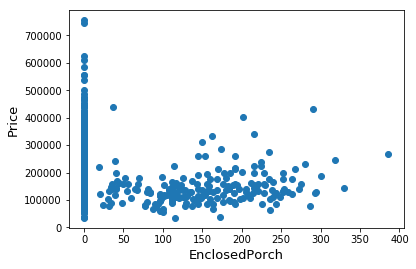

In [20]:

train = train.drop(train[(train['EnclosedPorch']>500)].index)
plot_outlier('EnclosedPorch')

In [21]:
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<np.exp(12.5))].index) # Dropping outliers 
train = train.drop(train[(train['LotArea']>30000)].index)
train = train.drop(train[(train['OpenPorchSF']>300)].index)
train = train.drop(train[(train['EnclosedPorch']>500)].index)

In [22]:
train = train.drop(train[(train['TotalSqFt']>60000) & (train['SalePrice']<np.exp(13.1))].index) # Dropping outliers

## Let's look at the distribution of our main variable of concern, sales price, to see if it is skewed, and if so, know how to fix the problem

Text(0.5,1,'Sale Price Distribution')

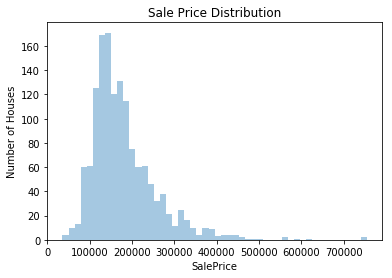

In [23]:
sns.distplot(train.SalePrice, kde=False) #kde is kernel density estimate. We want just a count of the number of houses
plt.ylabel('Number of Houses')
plt.title('Sale Price Distribution')


### Here is a QQ Plot of Sales Price. Essentially, it is a quick way to check normality. If the blue dots follow the red line, it means that sales price is normally distributed. 

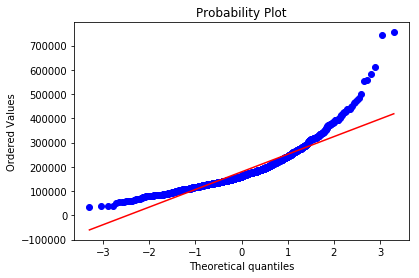

In [24]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### From the above plots, we now know that we need to transform the sales price. We will do so through a common transformation, taking the natural logarithm

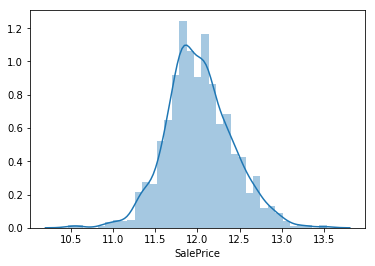

In [25]:
train['SalePrice'] = np.log(train['SalePrice'])   # Define logsale as log of sale price
sns.distplot(train['SalePrice'])   # Graph log of sale price



### Let's look again at the QQ Plot to check normality

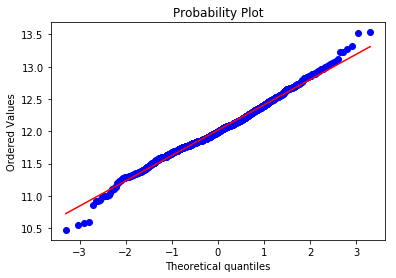

In [26]:
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### Sales is now normally distributed, which is great for using regressions of all kind.

### We don't want Sale Price for predicting because that would screw up predictions, so we will take it away from the training data set and save it somewhere else (specifically, as 'Price')

In [27]:
Price=train['SalePrice']
train = train.drop(['SalePrice'], axis=1)  # Get rid of Sale Price variable since that is our target


## Getting dummy variables for all objects so we can scale and make use of categorical variables

### And speaking of dummies...

In [28]:
HTML('<img src="https://media.giphy.com/media/10uoxQhDburBiE/giphy.gif">')

In [29]:
object_columns = train.select_dtypes(include=['object']).columns
train=pd.get_dummies(train, columns=object_columns)

## Let's now look at skewness

In [30]:
num_feat = train.dtypes[train.dtypes != "object"].index

skewed_feats = train[num_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print('There are {} variables to transform'.format(skewness.shape[0]))



Skew in numerical features: 

There are 696 variables to transform


In [31]:
from scipy.special import boxcox1p
lmbda = .15  # Hyperperameter to change around

for var in skewness.index:
    train[var] = boxcox1p(train[var], lmbda)

## Scaling Features
### This helps normalize other variables

In [32]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaled_train_df = pd.DataFrame(scaler.fit_transform(train))
scaled_train_df.columns = train.columns

In [33]:
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

## Cleaning Testing Dataset 
### (same thing as has been done before but for testing dataset) 

In [34]:
test["LotFrontage"] = test.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

#Replace necessary missing data with "None"
for col in ('BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2','BsmtExposure', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'MasVnrArea'):
    test[col] = test[col].fillna('None')
    
for col in ('GarageYrBlt', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea', 'MasVnrArea'):
    test[col] = test[col].fillna(0)
    
for col in ('Electrical', 'MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'MasVnrType', 'MasVnrArea', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional'): 
    test[col] = test[col].fillna(test[col].mode()[0]) 
    
test['TotalSqFt'] = test['LotArea'] + test['GrLivArea'] + test['GarageArea']+ test['1stFlrSF'] + test['TotalBsmtSF'] + test['BsmtUnfSF'] + test['LotFrontage'] + test['OpenPorchSF'] + test['OpenPorchSF'] + test['2ndFlrSF'] + test['WoodDeckSF']
test['Qual_Sq'] = np.square(test['OverallQual'])
test['Sq_Ft_Sq'] = np.square(test['TotalSqFt'])
   

    
num_feat = test.dtypes[test.dtypes != "object"].index

# Skewness
skewed_feats = test[num_feat].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]

lmbda = .15 

for var in skewness.index:
    test[var] = boxcox1p(test[var], lmbda)
    

object_columns = test.select_dtypes(include=['object']).columns
test=pd.get_dummies(test, columns=object_columns)

#scaled_test_df = test
#scaled_train_df = train

# Scaling

scaled_test_df = pd.DataFrame(scaler.fit_transform(test))
scaled_test_df.columns = test.columns

### We need to make sure that the train and test data sets have the same columns so we can use the trained model on the test data set. To do this, I took the intersection of the two data frames (scaled train and scaled test) and found the columns they had in common.

In [35]:
cols_in_comm = np.intersect1d(scaled_train_df.columns, scaled_test_df.columns)  # Intersecting to find columns in common
scaled_train_df = scaled_train_df[cols_in_comm]    # Subsetting the train dataset to include only the columns in common
scaled_test_df = scaled_test_df[cols_in_comm]  # Doing the same to the training data set

# Reindexing the new training and test datasets to be in order so that the models put correct weights on the different features.
scaled_train_df = scaled_train_df.reindex(sorted(scaled_train_df.columns), axis=1)  
scaled_test_df = scaled_test_df.reindex(sorted(scaled_test_df.columns), axis=1)

print(scaled_train_df.shape, scaled_test_df.shape)

(1423, 541) (1459, 541)


# Modelling with training set

### Now that we have the same number of columns in the training and test data set, we can move forward with our modelling.

## Train test split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(scaled_train_df, Price, test_size=.20, random_state=42)

### First import some useful packages for modelling

In [37]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, classification_report, accuracy_score, mean_squared_error
from sklearn import datasets, linear_model
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

### Function of graph to determine how bias changes as we increase sample size for a given model

In [38]:
## source: http://scikit-learn.org/0.15/auto_examples/plot_learning_curve.html (and from Tyler Folkman)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=make_scorer(mean_squared_error))
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    
    
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [39]:
def give_rsme(model):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                           mean_squared_error(y_test, y_pred_test)))
#def gridsearching(model, parameters):
#    gridsearch = GridSearchCV(model(), parameters)
#    print("Best Params: {}".format(gridsearch.best_params_))
#    give_rsme(gridsearch)
#    

def gridsearching(model, parameters):
    gridsearch = GridSearchCV(model(), parameters)
    gridsearch.fit(X_train, y_train)
    print("Best Params: {}".format(gridsearch.best_params_))
    y_pred_train = gridsearch.predict(X_train)
    y_pred_test = gridsearch.predict(X_test)
    print("Train MSE: {}\tTest MSE: {}".format(mean_squared_error(y_train, y_pred_train),
                                          mean_squared_error(y_test, y_pred_test)))


In [40]:
scaled_test_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,TotalSqFt,Utilities_AllPub,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.626,-0.854,-0.094,-1.017,0.459,-0.147,-0.202,-0.194,-0.290,-0.205,...,-0.064,0.064,-0.943,-0.016,0.226,0.000,0.917,-0.334,-1.072,1.713
1,0.571,-0.854,-0.094,0.260,0.459,-0.147,-0.202,-0.194,-0.290,-0.205,...,-0.064,0.064,-0.183,0.493,0.887,0.000,1.505,-0.433,-1.215,1.713
2,-0.523,1.139,-0.094,0.260,0.459,-0.147,-0.202,-0.194,-0.290,-0.205,...,-0.064,0.064,-0.183,0.046,0.807,0.000,1.142,0.843,0.680,1.713
3,-0.529,1.124,-0.094,0.260,0.459,-0.147,-0.202,-0.194,-0.290,-0.205,...,-0.064,0.064,0.490,0.043,0.207,0.000,1.451,0.875,0.680,1.713
4,0.454,-0.854,-0.094,-1.017,-2.178,-0.147,-0.202,-0.194,3.451,-0.205,...,-0.064,0.064,-0.943,0.445,-0.830,0.000,-0.932,0.680,0.398,1.713


In [41]:
scaled_train_df.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,BsmtCond_Fa,...,Street_Grvl,Street_Pave,TotRmsAbvGrd,TotalBsmtSF,TotalSqFt,Utilities_AllPub,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,-0.800,1.195,-0.130,0.248,0.446,-0.142,-0.195,-0.177,-0.294,-0.181,...,-0.046,0.046,0.964,-0.078,-0.152,0.027,-0.935,1.039,0.875,0.134
1,0.431,-0.868,-0.130,0.248,0.446,-0.142,-0.195,-0.177,-0.294,-0.181,...,-0.046,0.046,-0.234,0.428,0.054,0.027,1.339,0.154,-0.429,-0.619
2,-0.577,1.202,-0.130,0.248,0.446,-0.142,-0.195,-0.177,-0.294,-0.181,...,-0.046,0.046,-0.234,0.014,0.521,0.027,-0.935,0.974,0.827,0.134
3,-0.440,1.136,-0.130,0.248,0.446,-0.142,-0.195,-0.177,-0.294,-0.181,...,-0.046,0.046,0.397,-0.233,0.159,0.027,-0.935,-1.884,-0.720,-1.372
4,0.116,1.298,-0.130,1.273,0.446,-0.142,-0.195,-0.177,-0.294,-0.181,...,-0.046,0.046,1.480,0.299,1.281,0.027,1.088,0.941,0.731,0.134


## Use Gradient Boost to determine best features

In [42]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=10, 
                                   loss='huber', random_state =5)
give_rsme(GBoost)

Train MSE: 0.002516753195859639	Test MSE: 0.012302267347342145


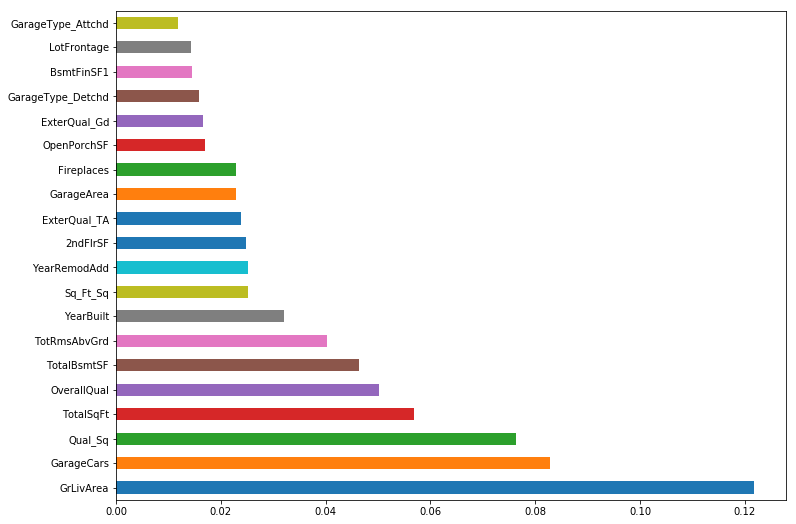

In [43]:
feat_importances = pd.Series(GBoost.feature_importances_, index=scaled_test_df.columns)   #Finding most important features
plt.subplots(figsize=(12,9))
feat_importances.nlargest(20).plot(kind='barh')    # Graphing best features along with their weight of importance

## Code for making this graph from KartikeDutta

### It appears that the most important variable, the Special, is above ground living area

In [44]:
HTML('<img src="http://25.media.tumblr.com/6100b9ec1b25123050f5870fe71e5061/tumblr_n1gmviVXrj1tsax3jo4_r1_250.gif" >')

### We don't want to use features that have low correlation, so let's stick to the top 140 (this includes dummy variables)

In [45]:
best_features = list(pd.DataFrame(feat_importances.nlargest(140)).index)
scaled_train_df2 = scaled_train_df[best_features]
scaled_test_df2 = scaled_test_df[best_features]

X_train, X_test, y_train, y_test = train_test_split(scaled_train_df2, Price, test_size=.20, random_state=12)


In [46]:
GBoost = GradientBoostingRegressor(n_estimators=2500, learning_rate=0.01,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=12, min_samples_split=10, 
                                   loss='huber', random_state =5)
give_rsme(GBoost)

Train MSE: 0.0052807806286316325	Test MSE: 0.009703897627746313


### SGD

In [47]:
SGD = SGDRegressor(tol=.0001, eta0=.0025)  # Define SGD using the parameters defined through the SGD Regressor

Train MSE: 0.012042378095910286	Test MSE: 0.013311648609335388


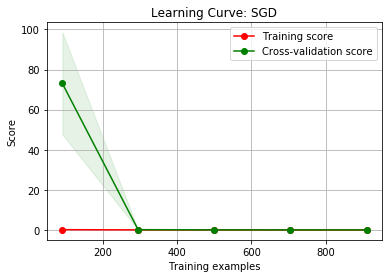

In [48]:
plot_learning_curve(SGD, "Learning Curve: SGD", X_train, y_train, cv=5)
give_rsme(SGD)

### Lasso

In [49]:
gridsearching(linear_model.Lasso, {"alpha": [0.001,0.0025, 0.005, 0.01, 0.025,0.005]})

Best Params: {'alpha': 0.0025}
Train MSE: 0.010832144296601173	Test MSE: 0.009440390231528163


In [50]:
lasso = linear_model.Lasso(alpha=0.0025)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

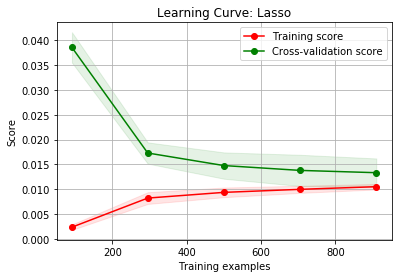

In [51]:
plot_learning_curve(lasso, "Learning Curve: Lasso", X_train, y_train, cv=5)

### Elastic Net

In [52]:
gridsearching(linear_model.ElasticNet,{"alpha": [0.001, 0.002, 0.0035,0.004,0.0045]})

Best Params: {'alpha': 0.004}
Train MSE: 0.010686490452066582	Test MSE: 0.009513526245352136


In [53]:
ENet = linear_model.ElasticNet(alpha=0.004)

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

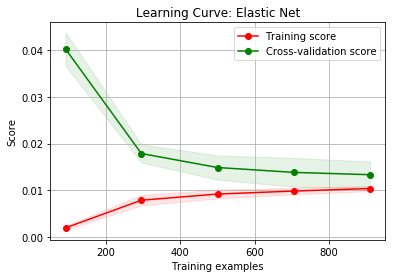

In [54]:
plot_learning_curve(ENet, "Learning Curve: Elastic Net", X_train, y_train, cv=5)

### Kernel Ridge

In [55]:
gridsearching(KernelRidge, {"alpha": [5,6,7,8,9,10], 'kernel': ['polynomial'], 
              'degree': [1,2,3,4,5], 'coef0': [5,6,6.8,7]})

Best Params: {'alpha': 6, 'coef0': 6, 'degree': 2, 'kernel': 'polynomial'}
Train MSE: 0.007724057189009467	Test MSE: 0.00978622139576325


In [56]:
kridge=KernelRidge(alpha=6, kernel='polynomial', degree=2, coef0=6) 

<module 'matplotlib.pyplot' from '/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py'>

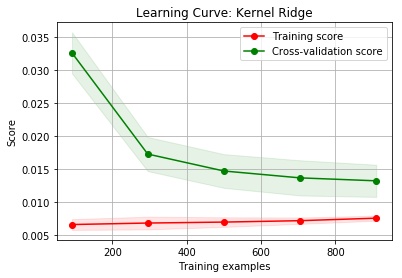

In [57]:
plot_learning_curve(kridge, "Learning Curve: Kernel Ridge", X_train, y_train, cv=5)

### Random Forest

In [58]:
gridsearching(RandomForestRegressor, {'n_estimators': [50,100,200,300,400,500], 'min_samples_leaf': [3,5,10,15]})


Best Params: {'min_samples_leaf': 3, 'n_estimators': 500}
Train MSE: 0.00528763757495479	Test MSE: 0.014979745948482491


In [59]:
rforest = RandomForestClassifier(n_estimators=500, min_samples_leaf=3)

### K Nearest Neighbors

In [60]:
gridsearching(KNeighborsRegressor, {'n_neighbors': [3,4,5,6,7], 'leaf_size': [10,20,30,40],'p':[1,2,3], 'weights':['distance']})

Best Params: {'leaf_size': 10, 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Train MSE: 0.0	Test MSE: 0.03212764365445595


In [61]:
kneighbors = KNeighborsRegressor(leaf_size=10, n_neighbors=7, p=1, weights='distance')

# Submissions to Kaggle! 
## Out of the models I tested, Elastic Net, Kernel Ridge, and Gradient Boost that had a low test RSME

In [62]:
def submit(model):
    model.fit(X_train, y_train)
    sub = pd.DataFrame()
    sub['Id'] = test_Id
    y_pred = np.exp(model.predict(scaled_test_df2))
    sub['SalePrice'] = y_pred
    sub.to_csv('submission_'+str(model)[0:7]+'.csv', index=False)


# Submission for Elastic Net

In [63]:
submit(ENet)

## Submission for GBoost

In [64]:
submit(GBoost)

## Submission for Kernel Ridge

In [65]:
submit(kridge)

## And now... for the best model tested...

In [66]:
HTML('<img src="https://media.giphy.com/media/rcqxcl5DGhM9q/giphy.gif">')

### Averaging y predictions from GBoost and elastic net (makeshift ensemble)

In [67]:
def averaging(model):
    model.fit(X_train, y_train)
    sub = pd.DataFrame()
    sub['Id'] = test_Id
    y_pred = np.exp(model.predict(scaled_test_df2))
    sub['SalePrice'] = y_pred
    return y_pred

y_pred_averages = 0.2*averaging(ENet) + 0.6*averaging(kridge) + 0.1*averaging(GBoost) + 0.1*averaging(SGD)

sub = pd.DataFrame()
sub['Id'] = test_Id
sub['SalePrice'] = y_pred_averages
sub.to_csv('averages', index=False)

# My personal Kaggle Record so far (using the above method):

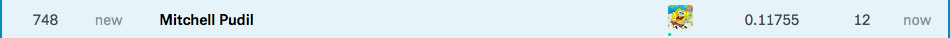

In [68]:
from IPython.display import display
from PIL import Image
path="/Users/mitchellpudil/Desktop/score.png"
display(Image.open(path))

In [69]:
HTML('<img src="https://media1.tenor.com/images/1dd03671ab0311a6ec446dd1ce4d91a9/tenor.gif?itemid=6103373">')